In this file, we show how to use the utility functions to run cross validation based on test sequence, and explore if we could improve the performance by seperating the data based on the operation mode.

In utility.py, we define a function `run_cv_one_motor` to run cross validation for a specified motor.

In this analysis, we use the dataset from motor 6, where we have the following operation modes:
- not moving: '20240425_093699', '20240425_094425', '20240426_140055'
- pickup and place: '20240503_163963', '20240325_155003'
- only moving the motor 6: '20240503_164675', '20240503_165189'

We will train a model for each operation mode, and compare the results by mixing all the operation modes together.

From this notebook, you should be able to:
- Understand how to use the utility functions to run cross validation.
- Have some insights about how to improve the performance of the model:
    - Should we select the features?
    - Should we seperate operation modes?
    - Should we consider the history in the prediciton as well?
    - Should we consider further pre-processing of the data to consider more features regarding the time-series?
        - Adjust for sequence-to-sequence variablity by subtracting the initial values?
        - Add features relating the change velocity?

In [65]:
from utility import read_all_test_data_from_path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import warnings
%matplotlib inline


# Subfunction for data preprocessing.
def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()


# Ignore warnings.
warnings.filterwarnings('ignore')

# Define the classification model.
# Define the steps of the pipeline
# 选出交叉验证评分最高的参数组合，作为最终的模型参数。
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler 归一化
    ('mdl', SVC(class_weight='balanced'))  # Step 2: SVM
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define hyperparameters to search
param_grid = {
    'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'mdl__gamma': [1e-4, 1e-3, 1e-2, 0.1, 1, 10]  # Kernel coefficient
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)

# Read all the dataset.
base_dictionary = '../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, remove_outliers, is_plot=False)

# Demo: How to use the utility function for cross validation.

## Basic usage

We can use `run_cv_one_motor` to easily run cross validation for one motor. For details of how to use this function, please have a look at its function signature (put your mouse on the function name will show the function signature). 

In the basic mode, we only need to specify values to four variables: `motor_idx, df_data, mdl, feature_list`.

For example, we could run a five-fold cross validation with a logistic regression model using the following code:

Model for motor 6:

 New run:

training performance, accuracy is: 0.9419724770642202
training performance, precision is: 0.8996983408748115
training performance, recall: 0.9086062452399086
training performance, F1: 0.9041303524062144



 New run:

testing performance, accuracy is: 0.8535778713168972
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0


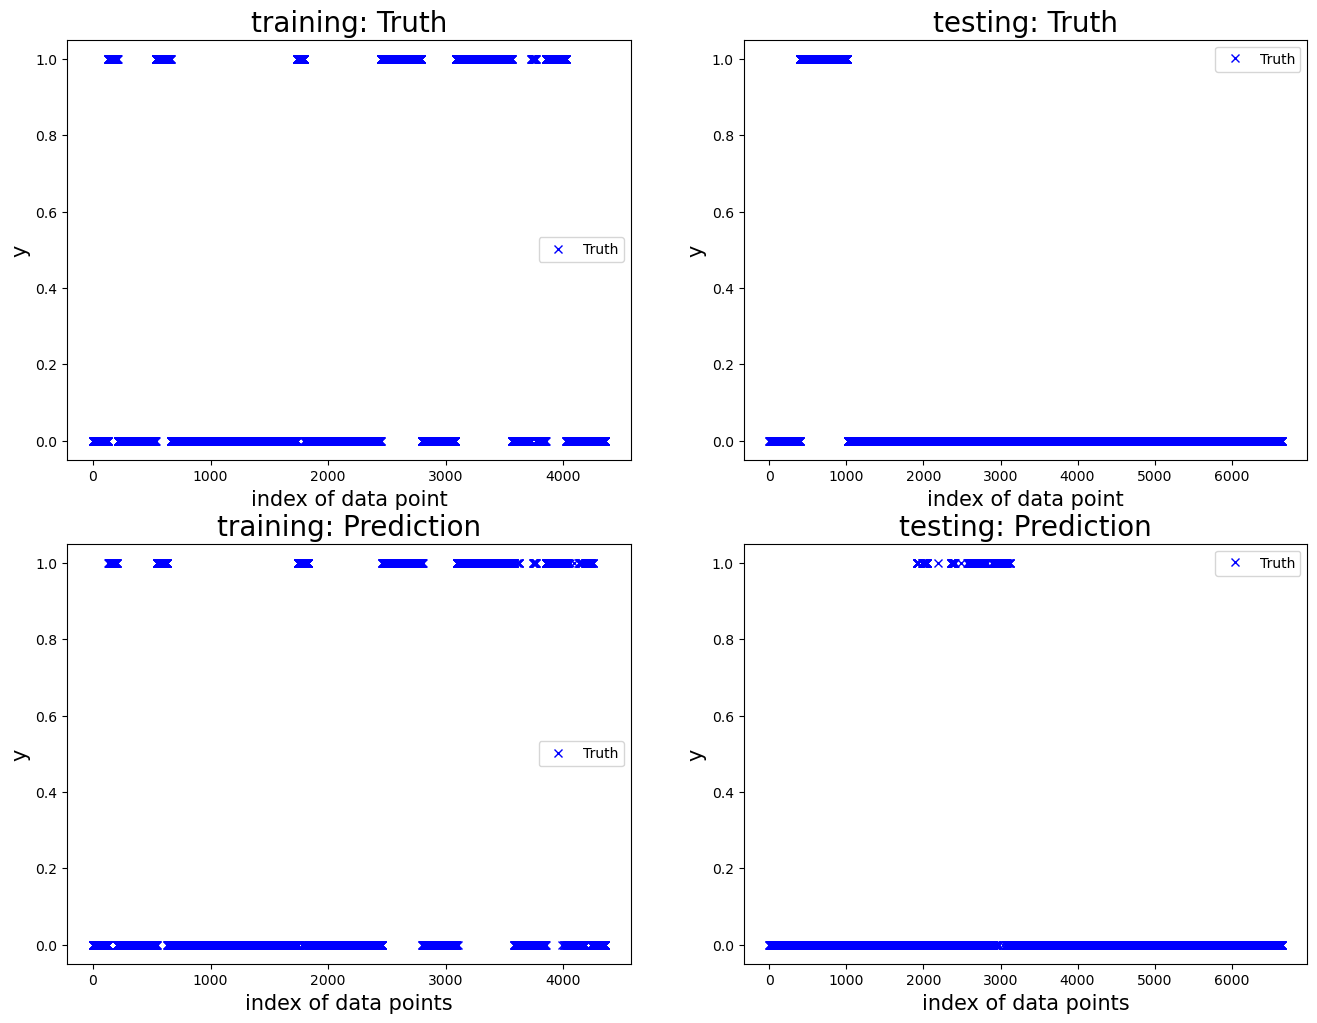


 New run:

training performance, accuracy is: 0.705778684723124
training performance, precision is: 0.34839449541284406
training performance, recall: 0.8210810810810811
training performance, F1: 0.4892109500805153



 New run:

testing performance, accuracy is: 0.354978354978355
testing performance, precision is: 0.354978354978355
testing performance, recall: 1.0
testing performance, F1: 0.5239616613418531


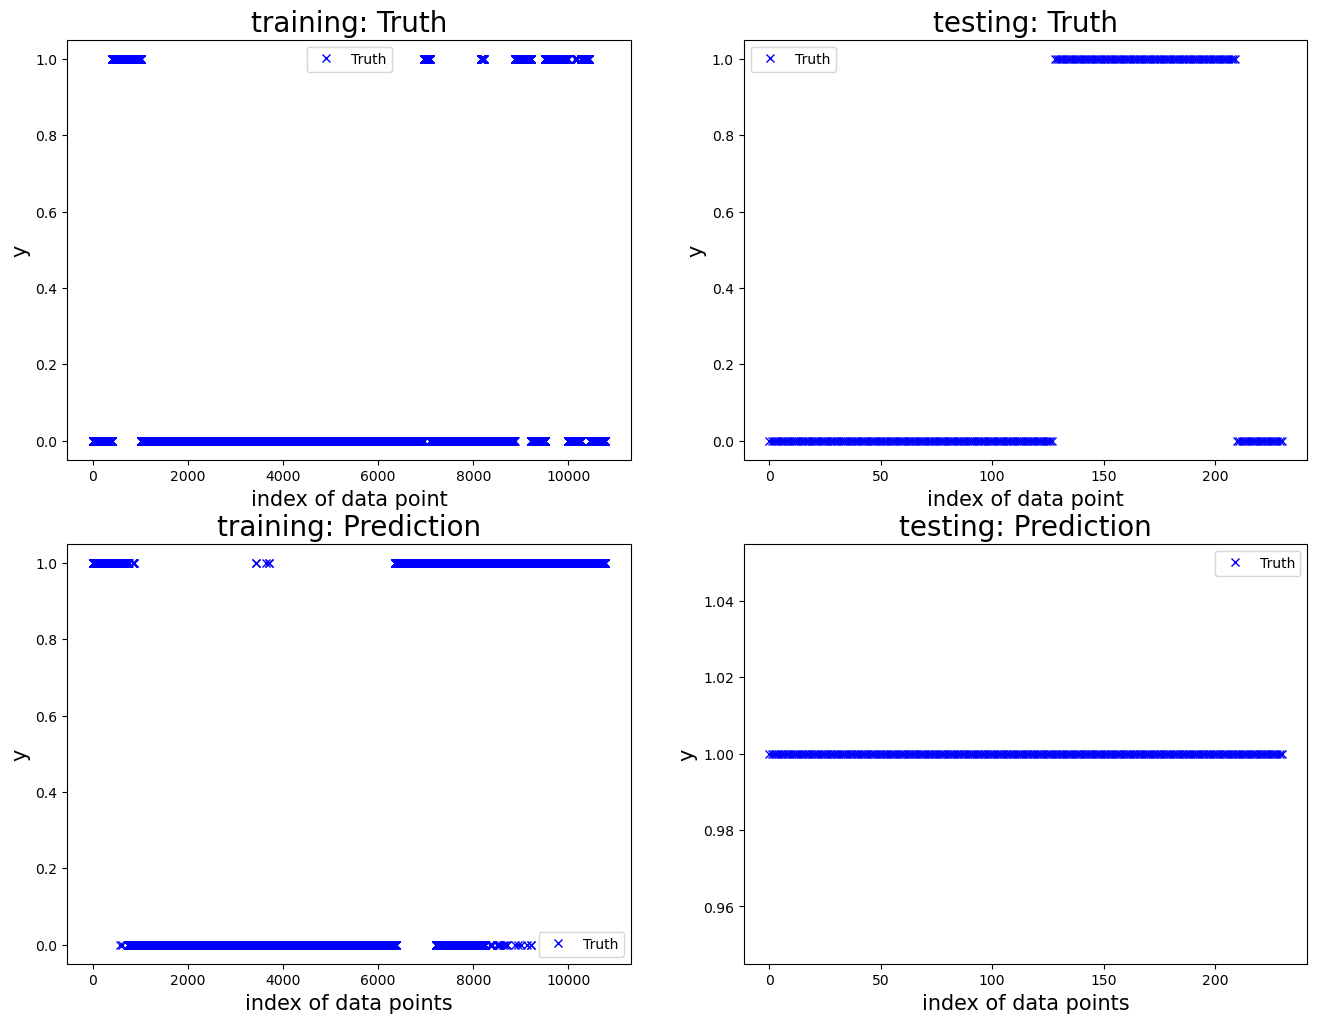


 New run:

training performance, accuracy is: 0.7239762724837352
training performance, precision is: 0.3654898060666335
training performance, recall: 0.8153078202995009
training performance, F1: 0.5047210300429185



 New run:

testing performance, accuracy is: 0.23035714285714284
testing performance, precision is: 0.23035714285714284
testing performance, recall: 1.0
testing performance, F1: 0.37445573294629897


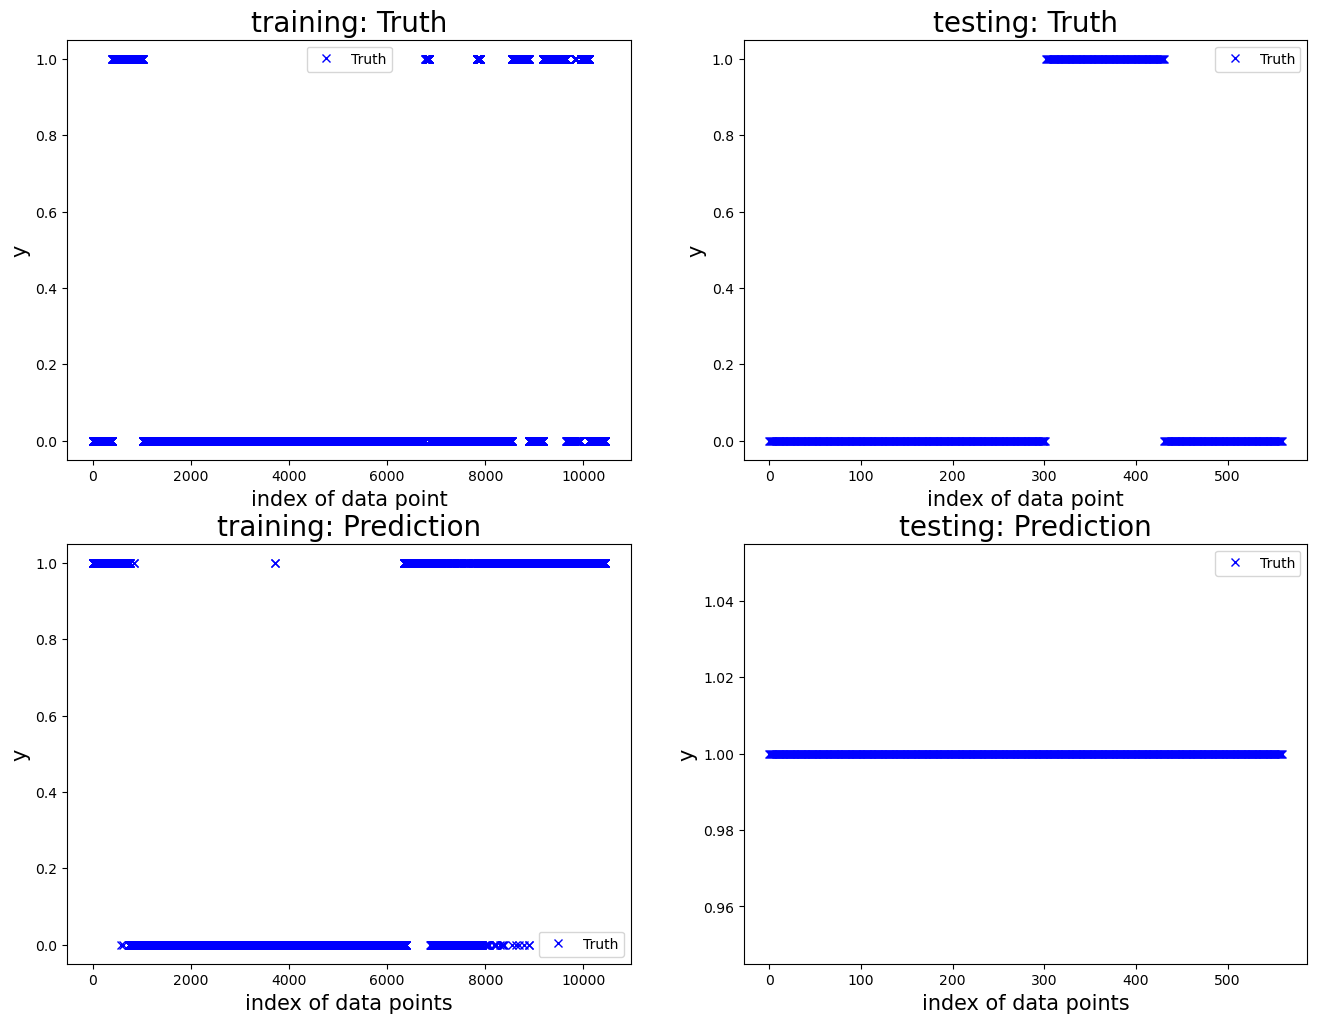


 New run:

training performance, accuracy is: 0.9509430176565008
training performance, precision is: 0.8099730458221024
training performance, recall: 0.9646869983948636
training performance, F1: 0.8805860805860806



 New run:

testing performance, accuracy is: 0.0603448275862069
testing performance, precision is: 0.0603448275862069
testing performance, recall: 1.0
testing performance, F1: 0.11382113821138211


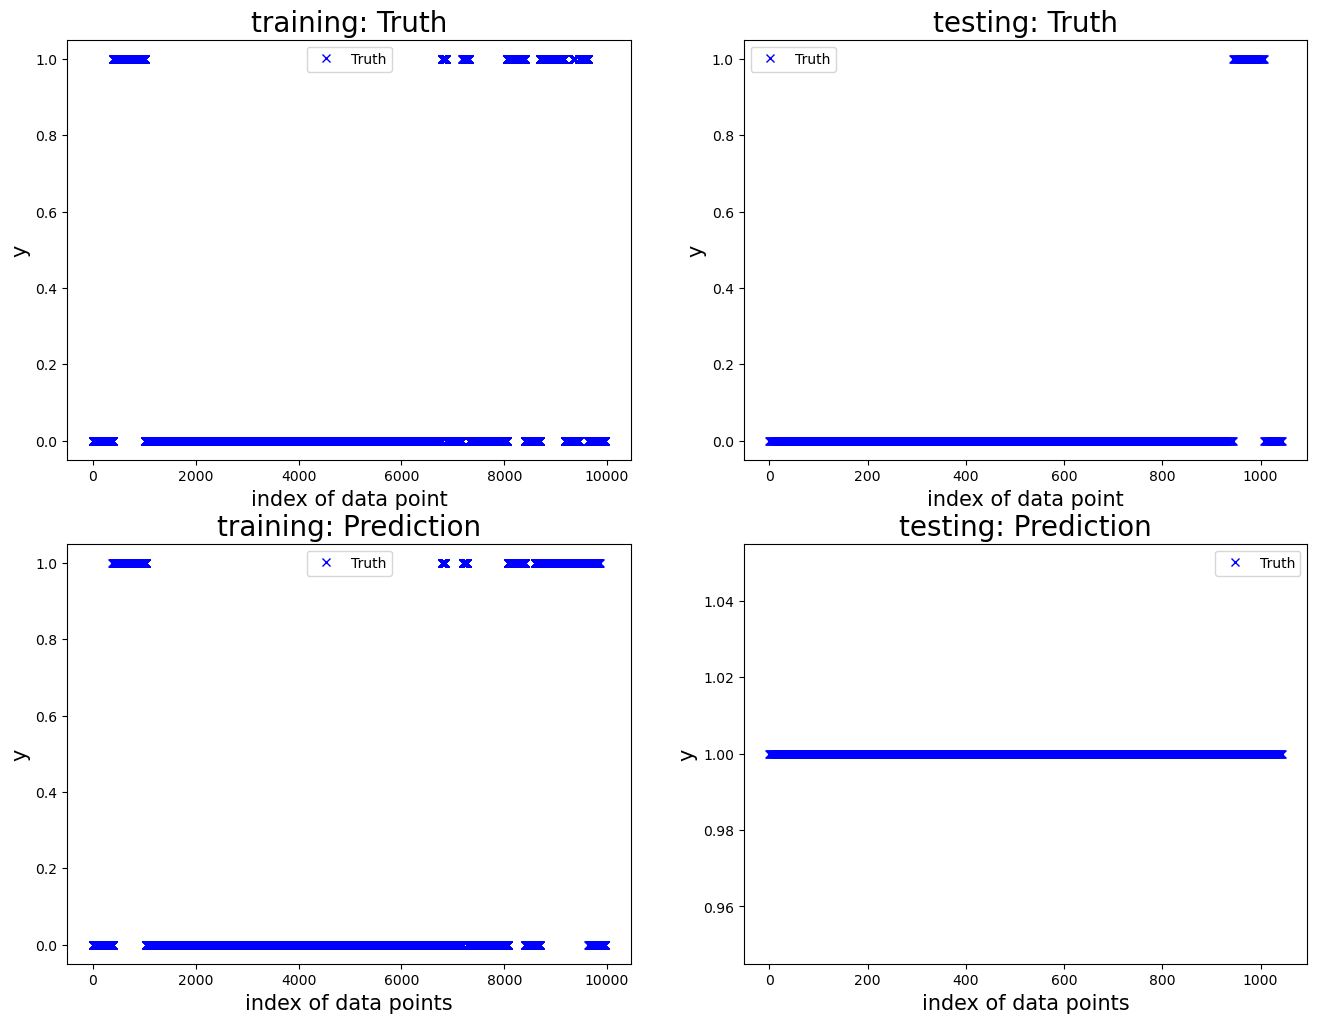


 New run:

training performance, accuracy is: 0.6894454020075028
training performance, precision is: 0.3217559093101785
training performance, recall: 0.841640378548896
training performance, F1: 0.465538300471122



 New run:

testing performance, accuracy is: 0.308964316797215
testing performance, precision is: 0.3002680965147453
testing performance, recall: 0.968299711815562
testing performance, F1: 0.4583901773533424


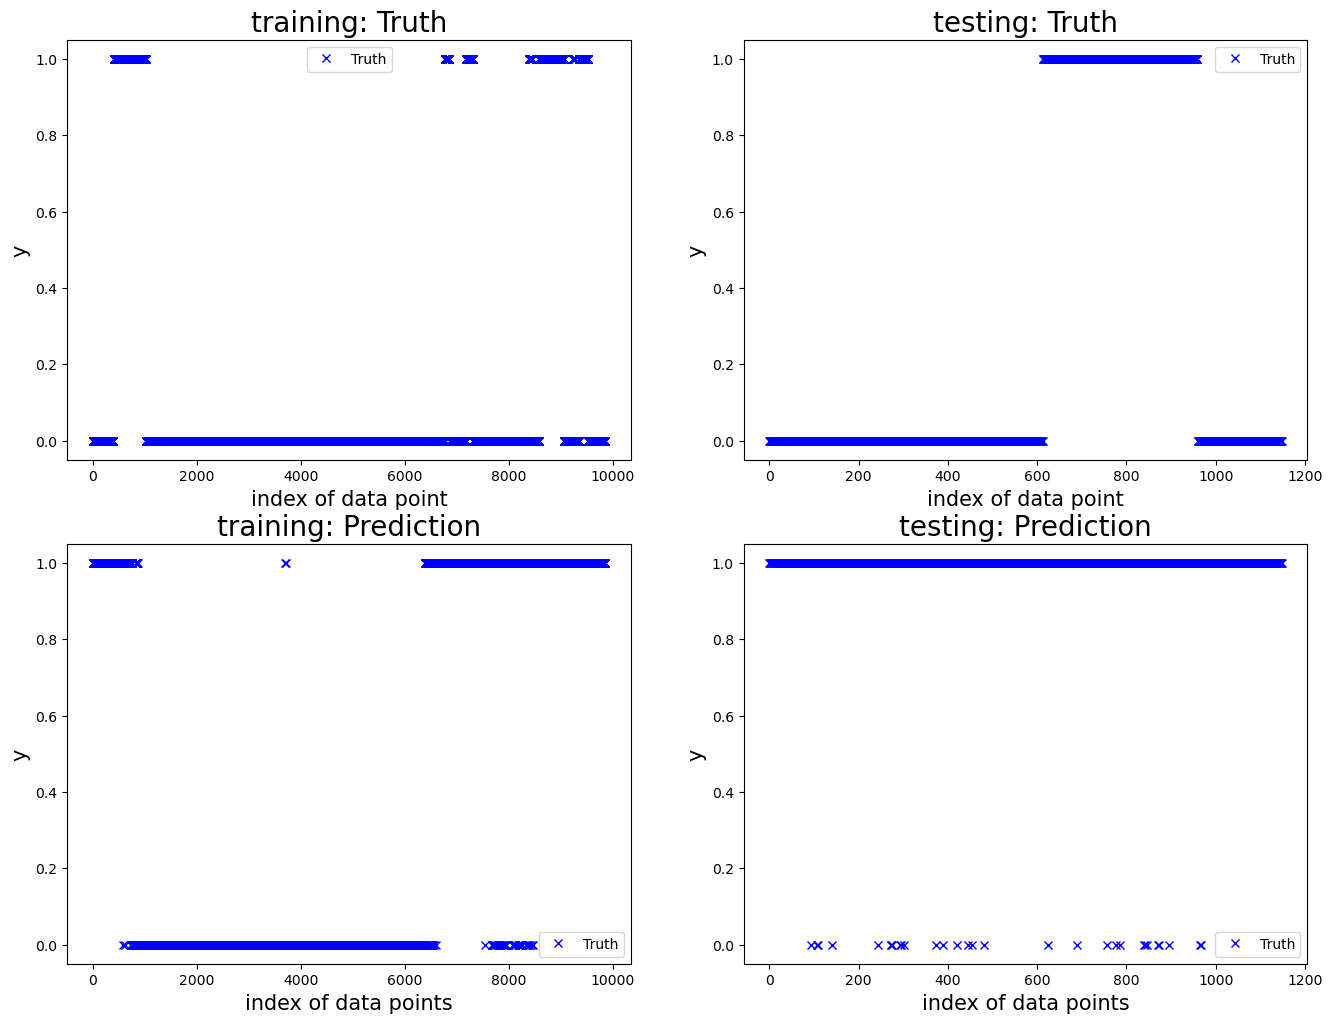


 New run:

training performance, accuracy is: 0.822145395179103
training performance, precision is: 0.4364675984752224
training performance, recall: 0.9462809917355371
training performance, F1: 0.5973913043478261



 New run:

testing performance, accuracy is: 0.8998330550918197
testing performance, precision is: 0.9585152838427947
testing performance, recall: 0.9145833333333333
testing performance, F1: 0.9360341151385928


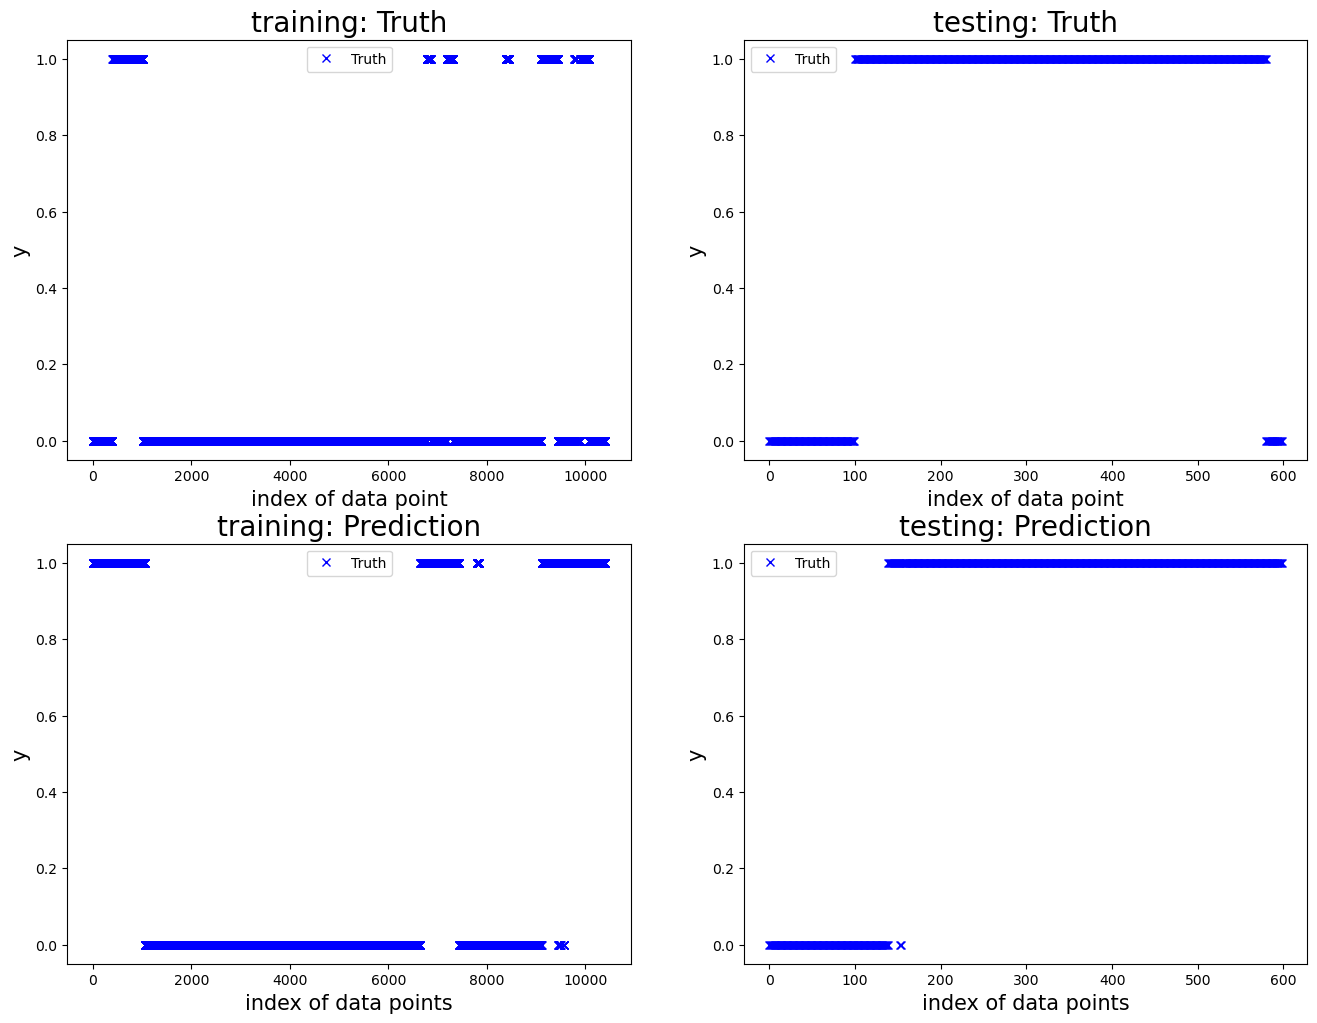


 New run:

training performance, accuracy is: 0.6806057645334636
training performance, precision is: 0.3259159361654304
training performance, recall: 0.8430232558139535
training performance, F1: 0.4700923974712271



 New run:

testing performance, accuracy is: 0.2728442728442728
testing performance, precision is: 0.2728442728442728
testing performance, recall: 1.0
testing performance, F1: 0.4287158746208291


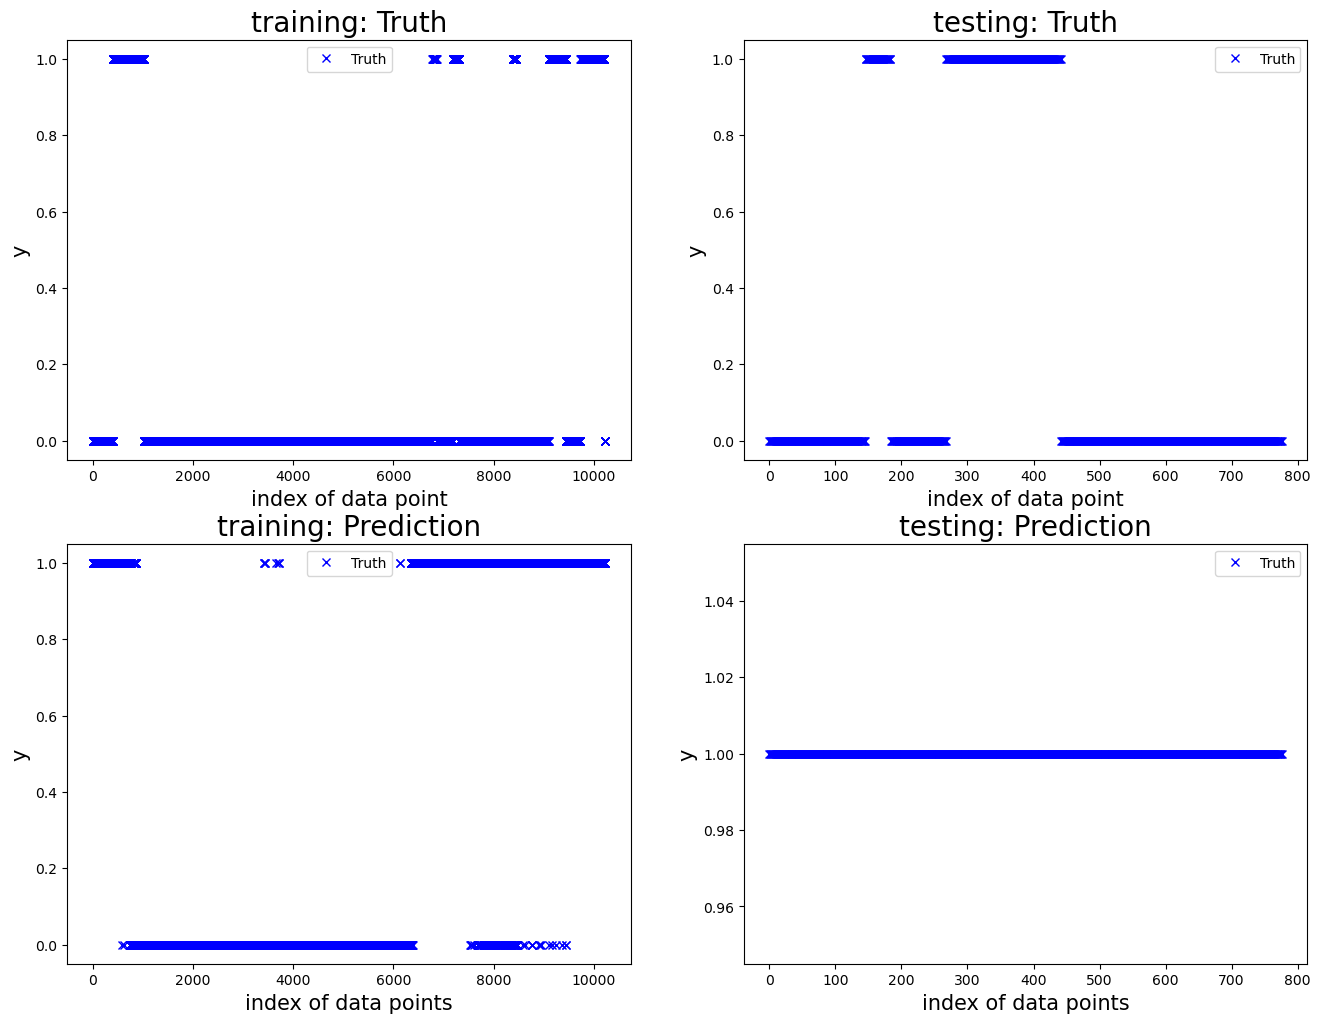

   Accuracy  Precision    Recall  F1 score
0  0.853578   0.000000  0.000000  0.000000
1  0.354978   0.354978  1.000000  0.523962
2  0.230357   0.230357  1.000000  0.374456
3  0.060345   0.060345  1.000000  0.113821
4  0.308964   0.300268  0.968300  0.458390
5  0.899833   0.958515  0.914583  0.936034
6  0.272844   0.272844  1.000000  0.428716


Mean performance metric and standard error:
Accuracy: 0.4258 +- 0.3218
Precision: 0.3110 +- 0.3133
Recall: 0.8404 +- 0.3719
F1 score: 0.4051 +- 0.3026


In [66]:
from utility import run_cv_one_motor

# Specify the test conditions you would like to include in the test.
df_data_experiment = df_data[df_data['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055',
                                                       '20240503_164675', '20240503_165189',
                                                       '20240503_163963', '20240325_155003'])]
# We want a five-fold cross validation.
n_cv = 7
# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

all_result = run_cv_one_motor(motor_idx=6, df_data=df_data_experiment, mdl=grid_search, feature_list=feature_list_all, n_fold=n_cv)


For each run in the cross validation, the function shows the performance on the training and testing dataset. This can be used for diagnosis and improving the model performance. In the end, the mean performance is printed. 
If you set the parameter `single_run_result=False`, only the final average performance is printed.

## Select the features

You can choose other features by changing the `feature_list`. Below you can find a demo for using only part of the features.

In [55]:
# Define the features.
feature_list_selected = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 
                    'data_motor_2_position', 'data_motor_2_temperature', 
                    'data_motor_3_position', 'data_motor_3_temperature', 
                    'data_motor_4_position', 'data_motor_4_temperature', 
                    'data_motor_5_position', 'data_motor_5_temperature', 
                    'data_motor_6_position', 'data_motor_6_temperature']

all_result = run_cv_one_motor(motor_idx=6, df_data=df_data_experiment, mdl=grid_search, feature_list=feature_list_selected, n_fold=n_cv, single_run_result=False)

Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.906945   0.000000  0.000000  0.000000
1  0.961039   1.000000  0.890244  0.941935
2  0.860714   1.000000  0.395349  0.566667
3  0.060345   0.060345  1.000000  0.113821
4  0.530896   0.298319  0.409222  0.345079
5  0.828047   1.000000  0.785417  0.879813
6  0.272844   0.272844  1.000000  0.428716


Mean performance metric and standard error:
Accuracy: 0.6315 +- 0.3513
Precision: 0.5188 +- 0.4624
Recall: 0.6400 +- 0.3798
F1 score: 0.4680 +- 0.3571



## Increase the feature space by concatenating the features in the past

Additionaly, we can use this program to generate new features by concatenating the features in the past by defining a sliding window. For doing this, you need to use the following parameters:
- window_size: the size of the sliding window. The features in the sliding window are concanetated into a feature vector.
- sample_step: we allow taking features every `sample_step` data points.

Below is a demo of taking every $10$ points in a past interval of $50$ points to create new features and make prediction. You can explore different values of `window_size` and `sample_step` to see how the performance changes.

In [67]:
window_size = 50
sample_step = 10

all_result = run_cv_one_motor(motor_idx=6, df_data=df_data_experiment, mdl=grid_search, feature_list=feature_list_all, 
            n_fold=n_cv, window_size=window_size, sample_step=sample_step, single_run_result=False)

Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.861578   0.000000  0.000000  0.000000
1  0.450549   0.450549  1.000000  0.621212
2  0.252446   0.252446  1.000000  0.403125
3  0.090452   0.065083  1.000000  0.122211
4  0.322727   0.315056  0.976945  0.476458
5  0.874545   0.874317  1.000000  0.932945
6  0.291209   0.291209  1.000000  0.451064


Mean performance metric and standard error:
Accuracy: 0.4491 +- 0.3053
Precision: 0.3212 +- 0.2878
Recall: 0.8538 +- 0.3766
F1 score: 0.4296 +- 0.3089



# Seperate operation mode

In the previous analysis, the dataset contains three different operation modes:
- not moving
- pick-up and place
- only moving motor 6.

In this section, we try to seperate the three operation modes, and train a specific model per operation mode. For each operation mode, we further compare:
- Select all the features V.S. select only the positions and the temperature of the current motor.
- window_size=0: only use current measurement V.S. window_size=5: use five previous points together as features.

Let's start by defining a supporting function.

In [68]:
from utility import run_cv_one_motor


# Define a function to run experiment.
def run_experiment(motor_id, df_data, mdl, window_size=1, sample_step=1, n_fold=5):
    print(f'window_size={window_size}, sample_step={sample_step}, all the features.')
    feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']
    _ = run_cv_one_motor(motor_id, df_data, mdl, feature_list_all, n_fold=n_fold, window_size=window_size, 
        sample_step=sample_step, single_run_result=False, mdl_type='clf')

    print(f'window_size={window_size}, sample_step={sample_step}, randomly pick features.')
    feature_list_self = ['time', 'data_motor_6_position', 'data_motor_6_temperature', 
                        'data_motor_5_position', 'data_motor_4_position', 'data_motor_3_position', 'data_motor_2_position', 'data_motor_1_position']
    _ = run_cv_one_motor(motor_id, df_data, mdl, feature_list_self, n_fold=n_fold, window_size=window_size, 
        sample_step=sample_step, single_run_result=False, mdl_type='clf')

## Not moving

In [69]:
# Not moving
df_data_mode = df_data[df_data['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055'])]
n_cv = 3

# Windowsize = 1.
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, n_fold=n_cv)

# Windowsize = 5.
window_size = 50
sample_step = 10
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, sample_step=sample_step, n_fold=n_cv)

window_size=1, sample_step=1, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.891775   0.793814  0.939024  0.860335
1  0.660714   0.404389  1.000000  0.575893
2  0.939655   0.000000  0.000000  0.000000


Mean performance metric and standard error:
Accuracy: 0.8307 +- 0.1492
Precision: 0.3994 +- 0.3969
Recall: 0.6463 +- 0.5606
F1 score: 0.4787 +- 0.4383


window_size=1, sample_step=1, randomly pick features.
Model for motor 6:
   Accuracy  Precision  Recall  F1 score
0  0.645022   0.000000     0.0  0.000000
1  0.512500   0.320896     1.0  0.485876
2  0.939655   0.000000     0.0  0.000000


Mean performance metric and standard error:
Accuracy: 0.6991 +- 0.2186
Precision: 0.1070 +- 0.1853
Recall: 0.3333 +- 0.5774
F1 score: 0.1620 +- 0.2805


window_size=50, sample_step=10, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.862637   0.787879  0.951220  0.861878
1  0.733855   0.484716  0.860465  0.620112
2  0.936683   0.

## Move only motor 6.

In [70]:
# Turning motor 6
df_data_mode = df_data[df_data['test_condition'].isin(['20240503_164675', '20240503_165189'])]
n_cv = 2

# Windowsize = 1.
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, n_fold=n_cv)

# Windowsize = 5.
window_size = 50
sample_step = 10
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, sample_step=sample_step, n_fold=n_cv)

window_size=1, sample_step=1, all the features.
Model for motor 6:
   Accuracy  Precision  Recall  F1 score
0  0.198664   0.000000     0.0  0.000000
1  0.272844   0.272844     1.0  0.428716


Mean performance metric and standard error:
Accuracy: 0.2358 +- 0.0525
Precision: 0.1364 +- 0.1929
Recall: 0.5000 +- 0.7071
F1 score: 0.2144 +- 0.3031


window_size=1, sample_step=1, randomly pick features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.322204   1.000000  0.154167  0.267148
1  0.272844   0.272844  1.000000  0.428716


Mean performance metric and standard error:
Accuracy: 0.2975 +- 0.0349
Precision: 0.6364 +- 0.5142
Recall: 0.5771 +- 0.5981
F1 score: 0.3479 +- 0.1142


window_size=50, sample_step=10, all the features.
Model for motor 6:
   Accuracy  Precision  Recall  F1 score
0  0.127273   0.000000     0.0  0.000000
1  0.291209   0.291209     1.0  0.451064


Mean performance metric and standard error:
Accuracy: 0.2092 +- 0.1159
Precision: 0.1456 +- 0.2059
Recal

## Pick up and place

In [71]:
# Turning motor 6
df_data_mode = df_data[df_data['test_condition'].isin(['20240503_163963', '20240325_155003'])]
n_cv = 2

# Windowsize = 0.
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, n_fold=n_cv)

# Windowsize = 5.
window_size = 50
sample_step = 10
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, sample_step=sample_step, n_fold=n_cv)

window_size=1, sample_step=1, all the features.
Model for motor 6:
   Accuracy  Precision  Recall  F1 score
0  0.093055   0.093055     1.0  0.170265
1  0.697998   0.000000     0.0  0.000000


Mean performance metric and standard error:
Accuracy: 0.3955 +- 0.4278
Precision: 0.0465 +- 0.0658
Recall: 0.5000 +- 0.7071
F1 score: 0.0851 +- 0.1204


window_size=1, sample_step=1, randomly pick features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.093055   0.093055  1.000000  0.170265
1  0.429069   0.173362  0.236311  0.200000


Mean performance metric and standard error:
Accuracy: 0.2611 +- 0.2376
Precision: 0.1332 +- 0.0568
Recall: 0.6182 +- 0.5400
F1 score: 0.1851 +- 0.0210


window_size=50, sample_step=10, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.093745   0.093745  1.000000  0.171421
1  0.531818   0.134783  0.089337  0.107452


Mean performance metric and standard error:
Accuracy: 0.3128 +- 0.3098
Precision: 0.1143 +- 0.0290

# Data preprocessing considering the time-series features.

## Remove the sequence-to-sequence variablity.

Since the tests are conducted at different time, we cannot garantee that the test conditions are exactly the same. For example, the environment temperature might be different from one test to another and impacts the temperatures of the motors. An easy way to adjust for this variability is to subtract the first value of each sequence from each value of the sequence.

Below is a simple code that implements this idea.

In [72]:
from utility import read_all_test_data_from_path
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
%matplotlib inline


def compensate_seq_bias(df: pd.DataFrame):
    ''' # Description
    Adjust for the sequence-to-sequence bias.
    '''
    # Tranform the features relative to the first data point.
    df['temperature'] = df['temperature'] - df['temperature'].iloc[0]
    df['voltage'] = df['voltage'] - df['voltage'].iloc[0]
    df['position'] = df['position'] - df['position'].iloc[0]


def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()        

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()        

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()


# Subfunction for data preprocessing.
def pre_processing(df: pd.DataFrame):
    ''' ### Description
    Preprocess the data:
    - remove outliers
    - Adjust for the sequence-to-sequence bias.
    - add new features about the difference between the current and previous n data point.
    '''     
    # Start processing.
    remove_outliers(df)
    compensate_seq_bias(df)


# Ignore warnings.
warnings.filterwarnings('ignore')

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler 归一化
    ('mdl', SVC(class_weight='balanced'))  # Step 2: SVM
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define hyperparameters to search
param_grid = {
    'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'mdl__gamma': [1e-4, 1e-3, 1e-2, 0.1, 1, 10]  # Kernel coefficient
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)

# Read all the dataset.
base_dictionary = '../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

# Specify the test conditions you would like to include in the test.
df_data_experiment = df_data[df_data['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055',
                                                       '20240503_164675', '20240503_165189',
                                                       '20240503_163963', '20240325_155003'])]

We run the same basic test as Sect. 1. It can be seen from the results that after adjusting the sequence-to-sequence variablity, the results improve significantly.

In [73]:
from utility import run_cv_one_motor

# We want a five-fold cross validation.
n_cv = 7
# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

all_result = run_cv_one_motor(motor_idx=6, df_data=df_data_experiment, mdl=grid_search, feature_list=feature_list_all, n_fold=n_cv, single_run_result=False)


Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.906795   0.000000  0.000000  0.000000
1  0.354978   0.354978  1.000000  0.523962
2  0.808929   1.000000  0.170543  0.291391
3  0.095785   0.062562  1.000000  0.117757
4  0.302002   0.302002  1.000000  0.463904
5  0.834725   0.933941  0.854167  0.892274
6  0.725869   0.484848  0.075472  0.130612


Mean performance metric and standard error:
Accuracy: 0.5756 +- 0.3182
Precision: 0.4483 +- 0.3919
Recall: 0.5857 +- 0.4766
F1 score: 0.3457 +- 0.3069



## Add change dynamics features

Another possiblity is to add features that consider the change dynamics of the measured data. This can be done by defining a variable $n_int$, and calculate the difference between the current and the previous $n_int$ data points. For example, if $n_int = 1$, the feature $x_{t-1} - x_t$ is added. If $n_int = 2$, the feature $x_{t-2} - x_{t-1} - x_t$ is added.

Below is an example that implements this idea.

In [74]:
from utility import read_all_test_data_from_path
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
%matplotlib inline

n_int = 20

# Subfunction for data preprocessing.
def pre_processing(df: pd.DataFrame):
    ''' ### Description
    Preprocess the data:
    - remove outliers
    - add new features about the difference between the current and previous n data point.
    '''
    
    def remove_outliers(df: pd.DataFrame):
        ''' # Description
        Remove outliers from the dataframe based on defined valid ranges. 
        Define a valid range of temperature and voltage. 
        Use ffil function to replace the invalid measurement with the previous value.
        '''
        df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
        df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
        df['temperature'] = df['temperature'].ffill()        

        df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
        df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
        df['voltage'] = df['voltage'].ffill()        

        df['position'] = df['position'].where(df['position'] >= 0, np.nan)
        df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
        df['position'] = df['position'].ffill()


    def cal_diff(df: pd.DataFrame, n_int: int):
        ''' # Description
        Calculate the difference between the current and previous n data point.
        '''
        # Tranform the features relative to the first data point.
        df['temperature'] = df['temperature'] - df['temperature'].iloc[0]
        df['voltage'] = df['voltage'] - df['voltage'].iloc[0]
        df['position'] = df['position'] - df['position'].iloc[0]

        # Calculate the difference between the current and previous n data point.
        df['temperature_diff'] = df['temperature'].diff(n_int)
        df['voltage_diff'] = df['voltage'].diff(n_int)
        df['position_diff'] = df['position'].diff(n_int)   

    # Start processing.
    remove_outliers(df)
    cal_diff(df, n_int)


# Ignore warnings.
warnings.filterwarnings('ignore')

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler 归一化
    ('mdl', SVC(class_weight='balanced'))  # Step 2: SVM
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define hyperparameters to search
param_grid = {
    'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'mdl__gamma': [1e-4, 1e-3, 1e-2, 0.1, 1, 10]  # Kernel coefficient
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)

# Read all the dataset.
base_dictionary = '../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

# Specify the test conditions you would like to include in the test.
df_data_experiment = df_data[df_data['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055',
                                                       '20240503_164675', '20240503_165189',
                                                       '20240503_163963', '20240325_155003'])]
n_cv = 7

In [75]:
from utility import run_cv_one_motor

feature_list_selected = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 
                    'data_motor_2_position', 'data_motor_2_temperature', 
                    'data_motor_3_position', 'data_motor_3_temperature', 
                    'data_motor_4_position', 'data_motor_4_temperature', 
                    'data_motor_5_position', 'data_motor_5_temperature', 
                    'data_motor_6_position', 'data_motor_6_temperature', 
                    'data_motor_1_position_diff', 'data_motor_1_temperature_diff', 
                    'data_motor_2_position_diff', 'data_motor_2_temperature_diff', 
                    'data_motor_3_position_diff', 'data_motor_3_temperature_diff', 
                    'data_motor_4_position_diff', 'data_motor_4_temperature_diff', 
                    'data_motor_5_position_diff', 'data_motor_5_temperature_diff', 
                    'data_motor_6_position_diff', 'data_motor_6_temperature_diff']
window_size = 100
sample_step = 10

all_result = run_cv_one_motor(motor_idx=6, df_data=df_data_experiment, mdl=grid_search, feature_list=feature_list_selected, 
            n_fold=n_cv, window_size=window_size, sample_step=sample_step, single_run_result=False)

Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.917037   0.818182  0.159935  0.267568
1  0.732143   0.732143  1.000000  0.845361
2  0.292517   0.292517  1.000000  0.452632
3  0.068108   0.068108  1.000000  0.127530
4  0.336893   0.336893  1.000000  0.503994
5  0.960417   0.960417  1.000000  0.979809
6  0.322188   0.322188  1.000000  0.487356


Mean performance metric and standard error:
Accuracy: 0.5185 +- 0.3477
Precision: 0.5043 +- 0.3303
Recall: 0.8800 +- 0.3175
F1 score: 0.5235 +- 0.3002

